# Introducción - Google Colab
Se importó todo lo que tenía el Notebook anterior a Google Colab para poder trabajarlo en una nube y no usar recursos propios. Se configuró el documento en Colab para acomodar las librerías utilizadas.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Aquí se importan las librerías y las mediciones que utilizamos para la creación de los mapas. Todas las librerías que utilizamos estaban ya instaladas en la nube de Google excepto Cartopy.

In [ ]:
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Se cambió la librería shapely porque provocaba conflictos con Cartopy, pues la versión no era compatible.

In [ ]:
!pip uninstall shapely

Se instala la antigua versión compatible.

In [ ]:
!pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xarray as xr #Manejo de netcdfs
import numpy as np #Manejo de matrices n-dimensionales
import cartopy.crs as ccrs #Sistema de referencia de coordenadas para los mapas
import cartopy.feature as cfeature #Características de los mapas
import matplotlib.pyplot as plt #Gráficos

In [ ]:
data = xr.open_dataset("/content/drive/MyDrive/Colab_Notebooks/era_2020.nc") 
data

<xarray.Dataset>
Dimensions:    (longitude: 281, latitude: 141, time: 8784)
Coordinates:
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 304.5 304.8 305.0
  * latitude   (latitude) float32 35.0 34.75 34.5 34.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-05-12 19:29:21 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

# Ejercicio 3.1
*Utiliza el mismo netcdf, a partir de las componentes horizontales a 10 m obten la rapidez del viento a esa altura. Utiliza la ley de potencias para extrapolar de 10 a 90 m, considera $\alpha=1/7$*
$$U(z)=U(z_r)\left(\frac{z}{z_r}\right)^{1/7}$$
Donde: <br>
z = Altura a la que se desea extrapolar <br>
zr = velocidad de referencia <br>
Uzr = Velocidad del viento a extrapolar a la altura zr <br>
Uz = velocidad estimada a la altura z <br>

###Paso 1
Obtenemos una nueva variable utilizando los datos U10 y V10 llamada WS10. Se segmentó la operación para evitar el operador `**` y se reemplazó por el método *.sqrt* de numpy.

In [ ]:
data["ws10"] = data["u10"]*data["u10"]
data["ws10"] += data["v10"]*data["v10"]
data["ws10"] = np.sqrt(data["ws10"])
data

<xarray.Dataset>
Dimensions:    (longitude: 281, latitude: 141, time: 8784)
Coordinates:
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 304.5 304.8 305.0
  * latitude   (latitude) float32 35.0 34.75 34.5 34.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    ws10       (time, latitude, longitude) float32 10.0 10.04 ... 0.6911 0.9809
Attributes:
    Conventions:  CF-1.6
    history:      2022-05-12 19:29:21 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

###Paso 2
Ahora implementamos la ley de potencias para extrapolar. $$U(z)=U(z_r)\left(\frac{z}{z_r}\right)^{1/7}$$

In [ ]:
# z = Altura a la que se desea extrapolar (90)
z = 90
zr = 10
Uzr = data["ws10"]
Uz = np.power(z/zr, (1/7))
Uz = Uz * Uzr
# Se guardaron las velocidades en la variable ws90 del arreglo
data["ws90"] = Uz
data

<xarray.Dataset>
Dimensions:    (longitude: 281, latitude: 141, time: 8784)
Coordinates:
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 304.5 304.8 305.0
  * latitude   (latitude) float32 35.0 34.75 34.5 34.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    u100       (time, latitude, longitude) float32 ...
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    ws10       (time, latitude, longitude) float32 10.0 10.04 ... 0.6911 0.9809
    ws90       (time, latitude, longitude) float32 13.69 13.75 ... 0.946 1.343
Attributes:
    Conventions:  CF-1.6
    history:      2022-05-12 19:29:21 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

# Ejercicio 3.2
*Realiza dos mapas de las velocidades extrapoladas a 90 m, acota el área de la gráfica únicamente para la Península de Yucatán. El primer mapa será para el promedio mensual de agosto y el segundo mapa será para el promedio mensual de diciembre. Verifica que ambos mapas tengan el mismo intervalo de velocidades para la visualización del colorbar.*

###Paso 1
Elegimos las longitudes y latitudes de la península de Yucatán.

In [ ]:
lons_yuc = np.array(data.longitude[128:128+29])
lats_yuc = np.array(data.latitude[48:48+37])
lons_yuc, lats_yuc

(array([267.  , 267.25, 267.5 , 267.75, 268.  , 268.25, 268.5 , 268.75,
        269.  , 269.25, 269.5 , 269.75, 270.  , 270.25, 270.5 , 270.75,
        271.  , 271.25, 271.5 , 271.75, 272.  , 272.25, 272.5 , 272.75,
        273.  , 273.25, 273.5 , 273.75, 274.  ], dtype=float32),
 array([23.  , 22.75, 22.5 , 22.25, 22.  , 21.75, 21.5 , 21.25, 21.  ,
        20.75, 20.5 , 20.25, 20.  , 19.75, 19.5 , 19.25, 19.  , 18.75,
        18.5 , 18.25, 18.  , 17.75, 17.5 , 17.25, 17.  , 16.75, 16.5 ,
        16.25, 16.  , 15.75, 15.5 , 15.25, 15.  , 14.75, 14.5 , 14.25,
        14.  ], dtype=float32))

###Paso 2
Creamos dos arreglos promedidados en el eje del tiempo con las velocidades extrapoladas a 90m en los meses de agosto y diciembre llamados `ws90_mean_08` y `ws90_mean_12` respectivamente.

In [ ]:
# Se crean los marcadores que segmentan los datos temporales
# en el dataframe por cada mes para facilitar la recuperación
# de los datos para los otros meses

i_jan = (0,743)
i_feb = (744,1439)
i_mar =(1440,2183)
i_apr = (2184,2903)
i_may = (2904,3647)
i_jun = (3648,4367)
i_jul = (4368,5111)
i_aug = (5112,5855)
i_sep = (5856,6575)
i_oct = (6576,7319)
i_nov = (7320,8039)
i_dic = (8040,8783)

ws90_mean_08 = data["ws90"][i_aug[0]:i_aug[1]+1]
ws90_mean_08 = ws90_mean_08.mean(axis=0)
ws90_mean_08

<xarray.DataArray 'ws90' (latitude: 141, longitude: 281)>
array([[10.81065  , 10.579233 , 10.382958 , ...,  7.9072323,  7.876662 ,
         7.83325  ],
       [10.608341 , 10.399813 , 10.283221 , ...,  7.8002725,  7.777985 ,
         7.7457037],
       [10.546647 , 10.437455 , 10.326326 , ...,  7.656487 ,  7.6437902,
         7.6410837],
       ...,
       [ 8.880013 ,  8.878456 ,  8.857962 , ...,  2.606817 ,  2.7823327,
         2.9079802],
       [ 8.644187 ,  8.641705 ,  8.632606 , ...,  2.63693  ,  2.8380606,
         2.9583554],
       [ 8.500901 ,  8.502022 ,  8.489087 , ...,  2.7046044,  2.9050188,
         3.0304766]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 304.5 304.8 305.0
  * latitude   (latitude) float32 35.0 34.75 34.5 34.25 ... 0.75 0.5 0.25 0.0

###Paso 3
Seleccionamos las latitudes y longitudes pertenecientes a Yucatán y las guardamos en una nueva variable.

In [ ]:
ws90_mean_08_yuc = np.array(ws90_mean_08[48:48+lats_yuc.size, 128:128+lons_yuc.size])
ws90_mean_08_yuc.shape

(37, 29)

###Paso 4
Con esos datos se proyecta la información al mapa de la península de Yucatán.

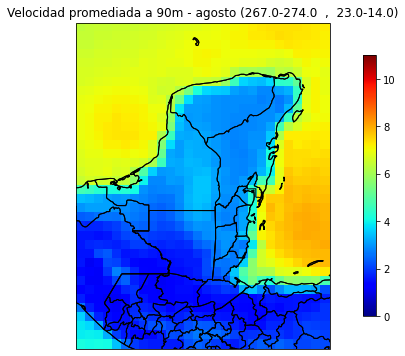

In [ ]:
plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree()) #Proyección del mapa 
##https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html

ax.set_extent([267,274,23,14]) #Límites del mapa [longitudes, latitudes]
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES.with_scale("10m"))# Límites de los países
ax.set_title(f"Velocidad promediada a 90m - agosto ({lons_yuc[0]}-{lons_yuc[-1]}  ,  {lats_yuc[0]}-{lats_yuc[-1]})")

#Malla de los datos, utilizando vmax para modificar la barra de colores
p = ax.pcolormesh(lons_yuc, lats_yuc, ws90_mean_08_yuc, cmap='jet', transform=ccrs.PlateCarree(), vmax=11, vmin=0) 
plt.colorbar(p, shrink=0.8) #Barra de colores

Se repiten los pasos para el mes de diciembre.

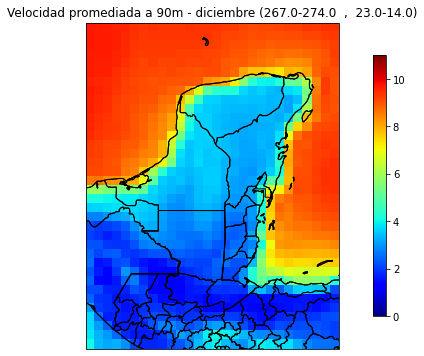

In [ ]:
ws90_mean_12 = data["ws90"][i_dic[0]:i_dic[1]+1]
ws90_mean_12 = ws90_mean_12.mean(axis=0)
ws90_mean_12_yuc = np.array(ws90_mean_12[48:48+lats_yuc.size,128:128+lons_yuc.size])
plt.figure(figsize=(12,6))
ax = plt.axes(projection =ccrs.PlateCarree())
ax.set_extent([267,274,23,14])
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES.with_scale("10m"))
ax.set_title(f"Velocidad promediada a 90m - diciembre ({lons_yuc[0]}-{lons_yuc[-1]}  ,  {lats_yuc[0]}-{lats_yuc[-1]})")
p = ax.pcolormesh(lons_yuc, lats_yuc, ws90_mean_12_yuc, cmap="jet", transform =ccrs.PlateCarree(),vmax=11, vmin=0)
plt.colorbar(p, shrink=0.8)

#Ejercicio 3.3
*Selecciona un punto al norte de Yucatán dentro del océano. Realiza un mapa del promedio anual de las velocidades y muestra el punto que seleccionaste.*

###Paso 1
Se define el punto elegido al norte de Yucatán (272.00, 21.75).

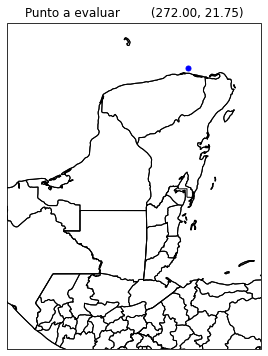

In [ ]:
plt.figure(figsize=(12,6))
ax = plt.axes(projection =ccrs.PlateCarree())
ax.set_extent([267,274,23,14])
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES.with_scale("10m"))
ax.set_title("Punto a evaluar        (272.00, 21.75)")
ax.plot(272, 21.75, marker='.', transform=cartopy.crs.PlateCarree(), markersize=10, color='blue')

##Paso 2
Se divide el dataframe a la región a analizar.

In [ ]:
ws90_mean_punto = data.sel(dict(latitude=slice(22.5,21.5), longitude = slice(271, 273)))
lons_yuc_punto = np.array(ws90_mean_punto.longitude)
lats_yuc_punto = np.array(ws90_mean_punto.latitude)
ws90_mean_punto = ws90_mean_punto["ws90"]
ws90_mean_punto = ws90_mean_punto.mean(axis=0)
ws90_mean_punto.shape

(5, 9)

##Paso 3

Se superponen las medidas sobre el mapa definido.

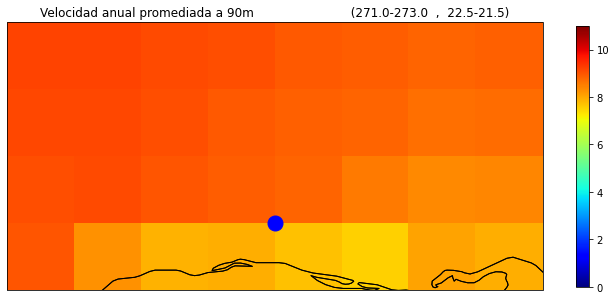

In [ ]:
plt.figure(figsize=(12,6))
ax = plt.axes(projection =ccrs.PlateCarree())
ax.set_extent([271, 273, 22.5, 21.5])
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES.with_scale("10m"))
ax.set_title(f"Velocidad anual promediada a 90m                         ({lons_yuc_punto[0]}-{lons_yuc_punto[-1]}  ,  {lats_yuc_punto[0]}-{lats_yuc_punto[-1]})")
p = ax.pcolormesh(lons_yuc_punto, lats_yuc_punto, ws90_mean_punto, cmap="jet", transform =ccrs.PlateCarree(),vmax=11, vmin=0)
ax.plot(272, 21.75, marker='o', transform=cartopy.crs.PlateCarree(), markersize=15, color='blue')
plt.colorbar(p, shrink=0.8)

#Ejercicio 3.4
*Para el punto que seleccionaste interpola la velocidad a 90 metros. Grafica la serie temporal.*

###Paso 1
Se elige la variable interpolada del dataframe y se guarda en una nueva variable. Se eliminan las columnas que se mantienen constantes (`latitude, longitude`).

In [ ]:
punto = data.interp(latitude=21.75, longitude=272)
punto_ws90 = punto.ws90.to_dataframe()
punto_ws90.drop(labels=["latitude", "longitude"], axis=1, inplace=True)
punto_ws90

,ws90
time,
2020-01-01 00:00:00,10.658780
2020-01-01 01:00:00,10.957721
2020-01-01 02:00:00,10.755184
2020-01-01 03:00:00,10.189590
2020-01-01 04:00:00,9.760061
...,...
2020-12-31 19:00:00,12.578834
2020-12-31 20:00:00,11.610567
2020-12-31 21:00:00,11.105289


##Paso 2
Finalmente se grafica la serie temporal.

Text(0, 0.5, 'Velocidad [m s$^{-1}$]')

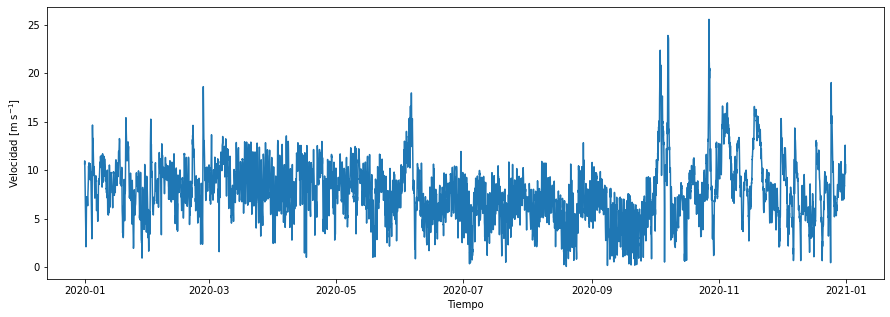

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(punto_ws90)
ax.set_xlabel("Tiempo")
ax.set_ylabel("Velocidad [m s$^{-1}$]")